<a href="https://colab.research.google.com/github/abhirup-ghosh/facial-expression-classifier-app/blob/main/notebooks/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Facial Emotion Recognition Predictor

## Dependencies

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, precision_score, recall_score, log_loss, accuracy_score

import tensorflow as tf
from tensorflow import keras

import pickle

sns.set_style("whitegrid")
sns.set_palette('muted')

In [165]:
for package in [pd, np, mpl, sns, sklearn, pickle, tf]:
    if package == pickle: print(f'{package.__name__:<12}: {package.format_version}')
    else: print(f'{package.__name__:<12}: {package.__version__}')

pandas      : 1.5.3
numpy       : 1.23.5
matplotlib  : 3.7.1
seaborn     : 0.12.2
sklearn     : 1.2.2
pickle      : 4.0
tensorflow  : 2.14.0


## Data Loading

The Kaggle dataset for this project can be downloaded from:
```
https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
```

Details of the dataset, including description of columns and associated datatypes, can be found [here](../data/README.md).

* Load all the data
* Separate into image arrays and labels
* Separate into training, validation and test sets

In [166]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [167]:
data = pd.read_csv('/content/drive/MyDrive/icml_face_data.csv')
data.columns = data.columns.str.strip()

In [168]:
def prepare_data(data):
    """ Prepare data for modeling
        input: data frame with labels und pixel data
        output: image and label array """

    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
      try:
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
      except ValueError: continue

    return image_array, image_label

In [169]:
input_shape = (48,48,1)

class_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]
num_classes = len(class_labels)

In [170]:
train_image_array, train_image_label = prepare_data(data[data['Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data['Usage']=='PublicTest'])
test_image_array, test_image_label = prepare_data(data[data['Usage']=='PrivateTest'])

In [171]:
train_image_array = train_image_array/255.
val_image_array = val_image_array/255.
test_image_array = test_image_array/255.

In [172]:
y_train_one_hot = tf.keras.utils.to_categorical(train_image_label, num_classes=num_classes)
y_val_one_hot = tf.keras.utils.to_categorical(val_image_label, num_classes=num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(test_image_label, num_classes=num_classes)

In [173]:
def plot_metrics(history):

    N = len(list(history.history.keys()))

    fig, axs = plt.subplots(ncols=N//2, figsize=(21,3))

    axs = axs.flatten()

    for idx, metric in enumerate(list(history.history.keys())[:N//2]):
        axs[idx].plot(history.history[metric])
        axs[idx].plot(history.history[f'val_{metric}'])

        axs[idx].set_title(metric)
        axs[idx].set_xlabel('Epoch')
        axs[idx].legend(['Train', 'Test'], loc='upper left')

        plt.tight_layout()

def plot_confusion_matrix(y_pred_labels, test_image_array):

    sorted_indices = np.argsort(y_pred, axis=1)[:, ::-1]
    # Extract the second-highest value indices from each row
    second_highest_indices = sorted_indices[:, 1]


    conf_matrix = confusion_matrix(test_image_label, y_pred_labels)
    conf_matrix_secondhighest = confusion_matrix(second_highest_indices, y_pred_labels)

    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels,
                ax=axs[0]
                )
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('True')
    axs[0].set_title('Confusion Matrix: Highest')

    sns.heatmap(conf_matrix_secondhighest, annot=True, fmt='d', cmap='Reds', cbar=False,
                xticklabels=class_labels,
                yticklabels=class_labels,
                ax=axs[1]
                )
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('True')
    axs[1].set_title('Confusion Matrix: Second Highest')

    plt.tight_layout()

def print_metrics(labels, predictions):

    predictions_labels = np.argmax(predictions, axis=1)
    return (f"LogLoss: {log_loss(labels, predictions):0.4f} \
              Accuracy: {accuracy_score(labels, predictions_labels):0.4f} \
              Precision: {precision_score(labels, predictions_labels, average='macro'):0.4f} \
              Recall: {recall_score(labels, predictions_labels, average='macro'):0.4f}")

113/113 [==============================] - 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: LogLoss: 1.2248               Accuracy: 0.5341               Precision: 0.4219               Recall: 0.4458
Test: LogLoss: 1.1977               Accuracy: 0.5469               Precision: 0.4326               Recall: 0.4559


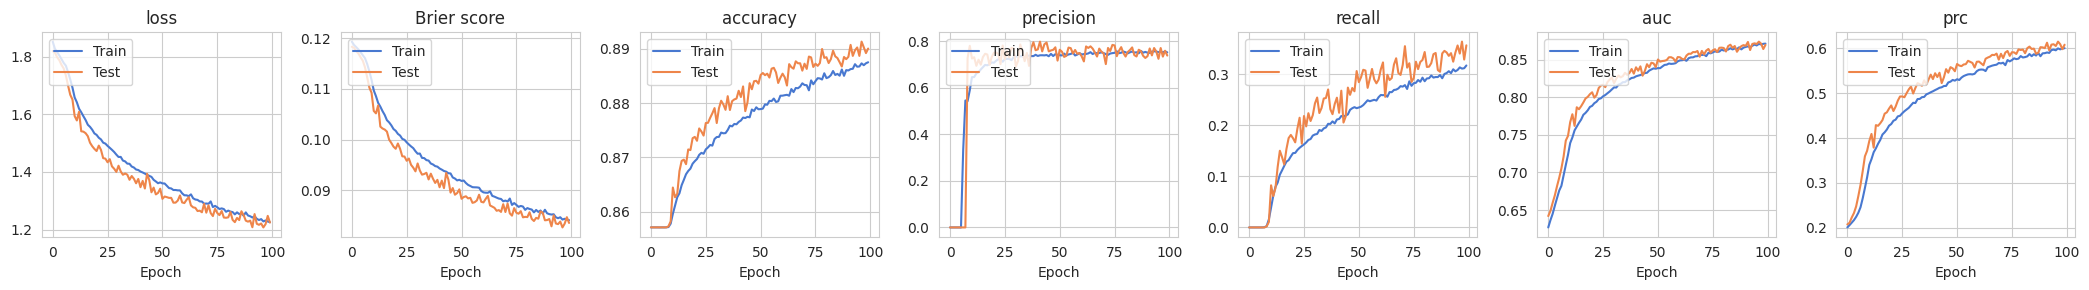

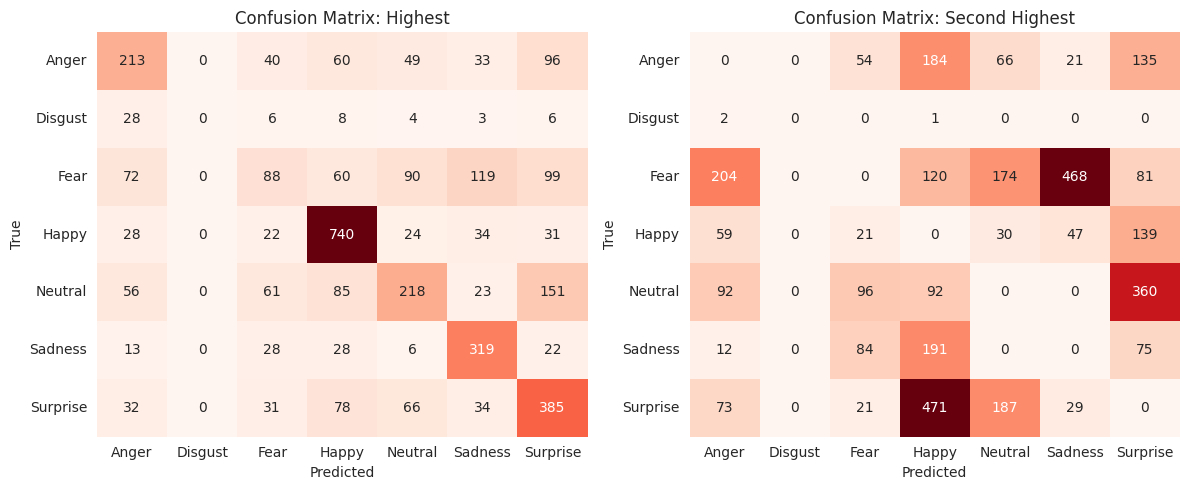

In [218]:
def make_model(input_shape=(48,48,1),
               num_classes=7,
               metrics=['accuracy'],
               learning_rate=1e-4):


    model = keras.models.Sequential()

    model.add(keras.layers.RandomFlip("horizontal", input_shape=input_shape))
    model.add(keras.layers.RandomTranslation(height_factor=0.1,width_factor=0.1))
    model.add(keras.layers.RandomContrast(factor=0.1))

    # Convolutional layers
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))

    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))

    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))

    model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))

    # Flatten the output for dense layers
    model.add(keras.layers.Flatten())

    # Dense layers
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.5))  # Adding dropout for regularization

    # Output layer with 7 units (for 7 emotion categories) and softmax activation
    model.add(keras.layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy()

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=METRICS)

    return model


# Define the EarlyStopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy' depending on your preference
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore weights from the epoch with the best value of the monitored quantity
    verbose=1
)

METRICS = [
          keras.metrics.MeanSquaredError(name='Brier score'),
          keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
          keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

model = make_model(input_shape=input_shape,
                   num_classes=num_classes,
                   metrics=METRICS)

# Display the model summary
#model.summary()

EPOCHS = 100
BATCH_SIZE = 512


# Train the model
history = model.fit(train_image_array, y_train_one_hot,
                    validation_data=(val_image_array, y_val_one_hot),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping],
                    verbose=0)

# Predictions
y_pred_val = model.predict(val_image_array)
y_pred_val_labels = np.argmax(y_pred_val, axis=1)

y_pred = model.predict(test_image_array)
y_pred_labels = np.argmax(y_pred, axis=1)

# Plotting
plot_metrics(history)
plot_confusion_matrix(y_pred_labels, test_image_array)


# Metrics
print(f'Validation: {print_metrics(val_image_label, y_pred_val)}')
print(f'Test: {print_metrics(test_image_label, y_pred)}')

In [181]:
model.save('emotion_classifier.h5')

model = keras.models.load_model('emotion_classifier.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [211]:
sample_test = test_image_array[0]
true_test_label = class_labels[test_image_label[0]]

In [212]:
true_test_label

'Anger'

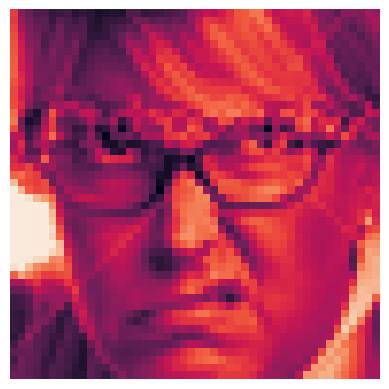

In [213]:
plt.imshow(sample_test)
plt.axis('off');

In [206]:
pred = model.predict(np.expand_dims(sample_test, axis=0))

1/1 [==============================] - 0s 86ms/step


In [207]:
dict(zip(class_labels, pred[0]))


{'Anger': 0.37458745,
 'Disgust': 0.09926288,
 'Fear': 0.09746297,
 'Happy': 0.0009802919,
 'Neutral': 0.22694874,
 'Sadness': 0.0009218902,
 'Surprise': 0.19983582}